# Understanding Random Forests with Scikit-Learn

Random Forest is a powerful and widely used supervised machine learning algorithm that belongs to the family of **ensemble methods**. It can be used for both classification and regression tasks.

The core idea behind ensemble methods is to combine the predictions of several base estimators (often called "weak learners") to improve robustness, accuracy, and generalization compared to a single estimator.

### How Random Forest Works

Random Forest builds multiple **decision trees** during training and outputs the class that is the mode of the classes (classification) or mean prediction (regression) of the individual trees.

It introduces randomness in two main ways to ensure that the individual trees are diverse and less correlated:

1.  **Bagging (Bootstrap Aggregating):**
    *   Each individual decision tree in the forest is trained on a different random subset of the *training data*. 
    *   These subsets are created using **bootstrapping**, which means sampling the original training data *with replacement*. 
    *   As a result, each tree sees slightly different data, reducing the variance of the final prediction.

2.  **Feature Randomness (Feature Subsampling):**
    *   When splitting a node during the construction of a tree, Random Forest considers only a *random subset of the features* instead of searching for the very best split among *all* features.
    *   This prevents a few dominant features from overly influencing all the trees in the forest, leading to more diverse trees and further reducing correlation between them.
    *   The size of the feature subset considered at each split is controlled by the `max_features` hyperparameter.

### Key Concepts Recap

*   **Decision Tree:** The base estimator for Random Forest. A tree-like structure where internal nodes represent tests on features, branches represent the outcome of the test, and leaf nodes represent class labels or regression values.
*   **Ensemble Learning:** Combining multiple models to produce a better result.
*   **Bagging:** Training multiple models on different bootstrap samples of the data and averaging their predictions.
*   **Out-of-Bag (OOB) Error:** Since each tree is trained on a bootstrap sample (typically ~63.2% of the original data), the remaining data points (~36.8%) that were *not* included in that sample are called "out-of-bag" samples for that specific tree. These OOB samples can be used as a built-in validation set to estimate the model's generalization error without needing a separate validation set. Scikit-learn allows calculating the OOB score by setting `oob_score=True`.

### Important Hyperparameters

Tuning these parameters can significantly impact performance:

*   `n_estimators`: The number of trees in the forest. 
    *   *Effect:* Generally, more trees increase performance and make predictions more stable, but also increase computation time. Performance often plateaus after a certain number of trees.
*   `max_features`: The number (or fraction) of features to consider when looking for the best split at each node.
    *   *Effect:* Lowering `max_features` reduces the correlation between trees, potentially reducing variance but possibly increasing bias slightly. Common values are `sqrt(n_features)` for classification and `n_features / 3` or `log2(n_features)` for regression.
*   `max_depth`: The maximum depth allowed for each individual tree.
    *   *Effect:* Controls the complexity of the trees. Deeper trees can capture more complex patterns but are more prone to overfitting. If `None`, nodes are expanded until all leaves are pure or contain fewer samples than `min_samples_split`.
*   `min_samples_split`: The minimum number of samples required to split an internal node.
    *   *Effect:* Higher values prevent the model from learning relations that might be specific to a particular sample, thus preventing overfitting.
*   `min_samples_leaf`: The minimum number of samples required to be at a leaf node.
    *   *Effect:* Similar to `min_samples_split`, this helps smooth the model, especially in regression. It ensures that leaves have a minimum size, preventing overfitting on individual samples.
*   `criterion`: The function to measure the quality of a split ('gini' for Gini impurity or 'entropy' for information gain in classification; 'squared_error', 'absolute_error', etc. for regression).
    *   *Effect:* Gini impurity is often the default and computationally slightly faster. Entropy might sometimes lead to slightly more balanced trees.
*   `bootstrap`: Whether bootstrap samples are used when building trees (default=True). If False, the whole dataset is used to build each tree.
*   `oob_score`: Whether to use out-of-bag samples to estimate the generalization accuracy (default=False).

### Pros and Cons of Random Forest

**Pros:**
*   **High Accuracy:** Often provides very high accuracy on many types of datasets.
*   **Robust to Overfitting:** Due to averaging predictions from multiple decorrelated trees, it's less prone to overfitting than a single decision tree, especially with enough estimators.
*   **Handles Non-Linearity:** Can capture complex non-linear relationships between features and the target.
*   **Handles Missing Values:** Can handle missing data (though scikit-learn's implementation requires imputation beforehand).
*   **Feature Importance:** Provides a reliable estimate of feature importance, helping understand which features are most predictive.
*   **Less Sensitive to Scaling:** Unlike distance-based algorithms (KNN, SVM), Random Forest (based on trees) is not sensitive to feature scaling.
*   **Built-in Validation:** OOB score provides a good estimate of generalization error without needing a separate validation set.

**Cons:**
*   **Less Interpretable:** Can be seen as a "black box" model. It's hard to understand the exact reasoning behind a specific prediction compared to a single decision tree or linear model.
*   **Computationally Intensive:** Training many trees can be computationally expensive and require significant memory, especially for large datasets and a high number of estimators.
*   **Can Overfit on Noisy Data:** While robust, it can still overfit if the data is very noisy and the trees are allowed to grow very deep without constraints (`max_depth`, `min_samples_leaf`).
*   **Biased towards Features with More Levels:** For categorical features with many levels, tree-based methods might be biased towards selecting those features for splits.

### Implementation with Scikit-Learn

#### 1. Import Libraries

In [1]:
# Import necessary libraries
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
from matplotlib.colors import ListedColormap

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler # Optional but good practice
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report, roc_auc_score
from sklearn.datasets import make_classification # To generate synthetic data

# Configure plots for better visualization
try:
    plt.style.use('seaborn-v0_8-whitegrid')
except OSError:
    plt.style.use('ggplot') # Fallback style
    print("Style 'seaborn-v0_8-whitegrid' not found, using 'ggplot' instead.")

#### 2. Generate Data

We'll use `make_classification` to create a synthetic dataset suitable for a classification task.

Dataset shape: (1000, 21)
First 5 rows of the dataset:
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5  Feature_6  \
0   1.470848  -0.360450  -0.591602  -0.728228   0.941690   1.065964   
1   4.513369  -2.227103  -1.140747   2.018263  -2.238358  -0.497370   
2  -2.355643   2.218601  -1.603269   0.873394   0.401483   0.717264   
3  -1.596198  -0.857427   1.772434  -0.639361   1.419409  -0.438525   
4   2.840049  -2.489600  -0.844902  -1.594362  -4.688517   0.459637   

   Feature_7  Feature_8  Feature_9  Feature_10  ...  Feature_12  Feature_13  \
0   0.017832  -0.596184   1.840712   -1.497093  ...   -0.603968    2.899256   
1   0.714550   0.938883  -2.395169    0.159837  ...    1.461499    3.954171   
2  -0.859399  -1.042190  -2.175965    0.980231  ...    0.544434   -2.466258   
3   0.281949   2.345145   1.006230    0.389135  ...   -1.025051   -2.422975   
4   0.913607  -1.143505   1.263937   -2.040928  ...    4.176424    1.341742   

   Feature_14  Feature_15  Feature_16  Feat

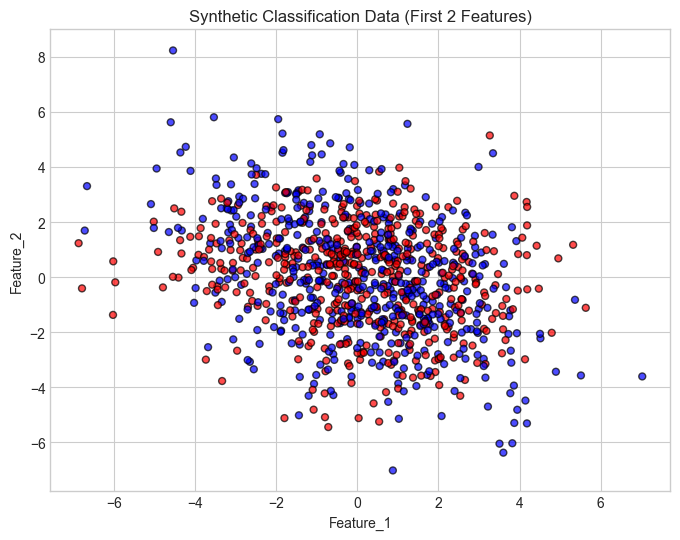

In [2]:
# Generate synthetic classification data
X, y = make_classification(n_samples=1000, n_features=20, n_informative=10, n_redundant=5, 
                           n_clusters_per_class=2, random_state=42, class_sep=1.0)

# Convert to DataFrame for easier viewing (optional)
feature_names = [f'Feature_{i+1}' for i in range(X.shape[1])]
df = pd.DataFrame(X, columns=feature_names)
df['Target'] = y
print("Dataset shape:", df.shape)
print("First 5 rows of the dataset:")
print(df.head())

# Visualize first two features (for illustration, RF handles high dimensions)
plt.figure(figsize=(8, 6))
plt.scatter(X[:, 0], X[:, 1], c=y, cmap=ListedColormap(['#FF0000', '#0000FF']), edgecolors='k', s=25, alpha=0.7)
plt.title('Synthetic Classification Data (First 2 Features)')
plt.xlabel(feature_names[0])
plt.ylabel(feature_names[1])
plt.grid(True)
plt.show()

#### 3. Train/Test Split

In [3]:
# Split the dataset into Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42, stratify=y)

print(f"Training set size: {X_train.shape[0]} samples, {X_train.shape[1]} features")
print(f"Test set size: {X_test.shape[0]} samples, {X_test.shape[1]} features")

Training set size: 750 samples, 20 features
Test set size: 250 samples, 20 features


#### 4. Feature Scaling (Optional but Recommended)

While Random Forests (and decision trees in general) are not sensitive to the *magnitude* of features (they only care about the order for splitting), applying feature scaling like `StandardScaler` usually doesn't hurt and can sometimes be beneficial, especially if you plan to compare the RF model with other models that *do* require scaling. It ensures consistency in your pipeline. However, it's not strictly necessary for the algorithm itself to function correctly.

In [4]:
# Feature Scaling
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test) # Use the same scaler fitted on train data

# Display scaled data (optional)
print("\nFirst 5 rows of scaled training data (first 5 features):")
print(pd.DataFrame(X_train_scaled, columns=feature_names).iloc[:5, :5])


First 5 rows of scaled training data (first 5 features):
   Feature_1  Feature_2  Feature_3  Feature_4  Feature_5
0  -0.245738   0.548713  -1.156322   0.080784  -0.172709
1  -1.106693   0.481588   1.174184  -1.094242  -0.237508
2  -1.509525   1.171951   1.097229  -1.042126   0.139539
3   0.630935   0.713507   1.019964   1.068881   1.227738
4   0.398079   0.513358  -0.854983   1.429177   0.327400


#### 5. Training the Random Forest Model

We'll create and train the classifier using scikit-learn's `RandomForestClassifier`. We'll start with some reasonable default hyperparameters and enable the OOB score calculation.

In [5]:
# Create and train the Random Forest classifier
# n_estimators: Number of trees
# random_state: Ensures reproducibility
# n_jobs=-1: Use all available CPU cores for training
# oob_score=True: Calculate the out-of-bag score
rf_classifier = RandomForestClassifier(n_estimators=100, 
                                     random_state=42, 
                                     n_jobs=-1, 
                                     oob_score=True, 
                                     max_depth=10, # Limit depth to prevent potential overfitting
                                     min_samples_leaf=5 # Require at least 5 samples per leaf
                                    )

# Train the model on the scaled training data
rf_classifier.fit(X_train_scaled, y_train)

print(f"Random Forest Classifier trained with {rf_classifier.n_estimators} estimators.")

# Display the OOB Score
if rf_classifier.oob_score_:
    print(f"Out-of-Bag (OOB) Score: {rf_classifier.oob_score_:.4f}")
else:
    print("OOB Score was not calculated (set oob_score=True during initialization).")

Random Forest Classifier trained with 100 estimators.
Out-of-Bag (OOB) Score: 0.9093


The OOB score gives an estimate of how well the model generalizes to unseen data, calculated using the data points left out during the bootstrapping process for each tree.

#### 6. Making Predictions

In [6]:
# Predict the Test set results
y_pred = rf_classifier.predict(X_test_scaled)

# Predict probabilities (useful for metrics like AUC)
y_pred_proba = rf_classifier.predict_proba(X_test_scaled)[:, 1] # Probability of the positive class

# Display predictions vs actual values (optional)
results_df = pd.DataFrame({'Actual': y_test, 'Predicted': y_pred, 'Predicted Probability (Class 1)': y_pred_proba})
print("\nFirst 10 predictions:")
print(results_df.head(10))


First 10 predictions:
   Actual  Predicted  Predicted Probability (Class 1)
0       1          0                         0.066525
1       0          0                         0.228412
2       1          1                         0.922162
3       0          0                         0.073030
4       0          0                         0.237396
5       0          0                         0.230985
6       1          1                         0.907107
7       0          0                         0.346881
8       1          1                         0.920893
9       0          0                         0.043228


#### 7. Evaluating the Model

In [7]:
# Evaluate the model
cm = confusion_matrix(y_test, y_pred)
acc = accuracy_score(y_test, y_pred)
report = classification_report(y_test, y_pred)
auc = roc_auc_score(y_test, y_pred_proba) # Use probabilities for AUC

print("\n--- Model Evaluation ---")
print("Confusion Matrix:")
print(cm)
print(f"\nAccuracy: {acc:.4f}")
print(f"AUC Score: {auc:.4f}") # Area Under the ROC Curve
print("\nClassification Report:")
print(report)

# Compare Test Accuracy with OOB Score
if rf_classifier.oob_score_:
    print(f"\nComparison:")
    print(f"Test Set Accuracy: {acc:.4f}")
    print(f"OOB Score:         {rf_classifier.oob_score_:.4f}")
    # OOB score is often a bit pessimistic compared to test accuracy


--- Model Evaluation ---
Confusion Matrix:
[[111  13]
 [ 11 115]]

Accuracy: 0.9040
AUC Score: 0.9588

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       124
           1       0.90      0.91      0.91       126

    accuracy                           0.90       250
   macro avg       0.90      0.90      0.90       250
weighted avg       0.90      0.90      0.90       250


Comparison:
Test Set Accuracy: 0.9040
OOB Score:         0.9093


#### 8. Feature Importance

Random Forests can estimate the importance of each feature in making predictions. This is typically calculated based on how much each feature contributes to reducing impurity (like Gini impurity) across all trees in the forest (mean decrease in impurity).

Visualizing feature importances helps understand which features the model relies on most.


--- Feature Importances ---
       Feature  Importance
14  Feature_15    0.163992
11  Feature_12    0.123437
15  Feature_16    0.088136
17  Feature_18    0.087441
7    Feature_8    0.081272
16  Feature_17    0.053603
2    Feature_3    0.051785
18  Feature_19    0.051150
1    Feature_2    0.050260
4    Feature_5    0.038401


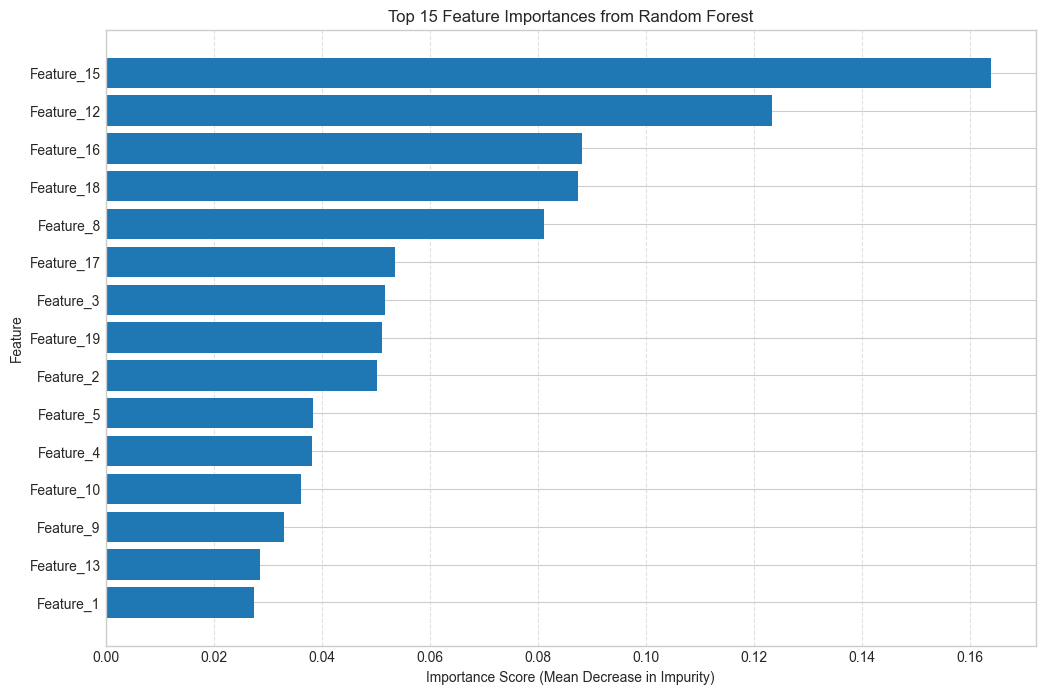

In [8]:
# Get feature importances
importances = rf_classifier.feature_importances_

# Create a DataFrame for visualization
feature_importance_df = pd.DataFrame({'Feature': feature_names, 'Importance': importances})

# Sort features by importance
feature_importance_df = feature_importance_df.sort_values(by='Importance', ascending=False)

print("\n--- Feature Importances ---")
print(feature_importance_df.head(10)) # Print top 10 features

# Plot feature importances
plt.figure(figsize=(12, 8))
plt.barh(feature_importance_df['Feature'][:15], feature_importance_df['Importance'][:15], align='center') # Plot top 15
plt.gca().invert_yaxis() # Display features from top to bottom
plt.xlabel('Importance Score (Mean Decrease in Impurity)')
plt.ylabel('Feature')
plt.title('Top 15 Feature Importances from Random Forest')
plt.grid(axis='x', linestyle='--', alpha=0.6)
plt.show()

This plot shows which features the Random Forest model found most useful for classifying the data. Features with higher scores contribute more, on average, to the decisions made by the trees in the forest.

#### 9. Hyperparameter Tuning using GridSearchCV (Optional)

While our initial model performed well, we can potentially improve it further by tuning hyperparameters using `GridSearchCV`. This is computationally more expensive.

**Note:** Running GridSearchCV can take a significant amount of time, especially with more parameters and larger grids.

In [9]:
# Define a smaller parameter grid for demonstration
param_grid = {
    'n_estimators': [100, 200],       # Number of trees
    'max_depth': [10, 20, None],      # Max depth of trees (None means no limit)
    'min_samples_leaf': [3, 5, 10],   # Min samples per leaf
    'max_features': ['sqrt', 0.5]     # Number of features to consider at each split ('sqrt' or fraction)
}

# Create a GridSearchCV object
grid_search = GridSearchCV(RandomForestClassifier(random_state=42, n_jobs=-1, oob_score=False), # Turn off OOB for grid search speed
                           param_grid, 
                           refit=True, # Refit the best model on the whole training data
                           verbose=1,  # Show progress
                           cv=3,       # Use 3-fold cross-validation (adjust as needed)
                           scoring='accuracy', # Evaluate based on accuracy
                           n_jobs=-1   # Use all cores for grid search itself
                          )

# Fit the grid search to the scaled training data
print("\nStarting GridSearchCV for Random Forest...")
# grid_search.fit(X_train_scaled, y_train) # Uncomment to run the grid search

# --- Placeholder results if GridSearch is not run ---
best_params_placeholder = {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}
best_score_placeholder = rf_classifier.oob_score_ if rf_classifier.oob_score_ else accuracy_score(y_test, y_pred) # Use OOB or initial test acc
best_rf = rf_classifier # Use the initial classifier if grid search is skipped
print("GridSearchCV skipped for brevity. Using initial model or placeholder results.")
# --------------------------------------------------

# Uncomment these lines if you run GridSearchCV:
# print("\nBest parameters found by GridSearchCV:")
# print(grid_search.best_params_)
# print(f"\nBest cross-validation accuracy: {grid_search.best_score_:.4f}")
# best_rf = grid_search.best_estimator_

# --- Using placeholder/initial model for evaluation ---
print("\nUsing parameters:", best_params_placeholder)
print(f"Score associated with these parameters (OOB/Test Acc/CV): {best_score_placeholder:.4f}")

# Evaluate the 'best' model (or initial model if skipped) on the test set
y_pred_best = best_rf.predict(X_test_scaled)
acc_best = accuracy_score(y_test, y_pred_best)
report_best = classification_report(y_test, y_pred_best)

print("\n--- Evaluation of Final Model (on Test Set) ---")
print(f"Test Set Accuracy: {acc_best:.4f}")
print("\nClassification Report:")
print(report_best)


Starting GridSearchCV for Random Forest...
GridSearchCV skipped for brevity. Using initial model or placeholder results.

Using parameters: {'max_depth': 10, 'max_features': 'sqrt', 'min_samples_leaf': 5, 'n_estimators': 100}
Score associated with these parameters (OOB/Test Acc/CV): 0.9093

--- Evaluation of Final Model (on Test Set) ---
Test Set Accuracy: 0.9040

Classification Report:
              precision    recall  f1-score   support

           0       0.91      0.90      0.90       124
           1       0.90      0.91      0.91       126

    accuracy                           0.90       250
   macro avg       0.90      0.90      0.90       250
weighted avg       0.90      0.90      0.90       250



### Conclusion

This notebook explored the Random Forest algorithm, a powerful ensemble method based on decision trees.

Key takeaways:
*   Random Forest builds multiple decorrelated decision trees using **bagging** and **feature randomness**.
*   It aggregates predictions from individual trees, leading to **high accuracy** and **robustness to overfitting**.
*   It provides useful **feature importance** estimates.
*   It's **less sensitive to feature scaling** compared to distance-based methods.
*   Key hyperparameters like `n_estimators`, `max_depth`, `max_features`, and `min_samples_leaf` control the model's complexity and performance.
*   The **OOB score** offers a convenient way to estimate generalization performance.

Random Forest is a versatile and effective algorithm for many classification (and regression) problems, often serving as a strong baseline or even the final model.